# Introduction to GeoPandas

This notebook is self-contained, and has code used in the "Intro to GeoPandas" video on our [youtube channel](https://www.youtube.com/channel/UC34uByppapyrr-gubZMd9OQ).  Please feel free to reach out with any questions. 

Basis für dieses Notbook ist dieses Video: Geospatial Programming: Intro to GeoPandas 
https://www.youtube.com/watch?v=oFajY3FOq6A

In [2]:
import pandas as pd
import geopandas as gpd
import papermill as pm

In [ ]:
''' 
### THIS FIELD DOES NOT WORK YET! ###

# Load the energy consumption data for Berlin as a GeoDataFrame
energy_data = gpd.read_file('https://raw.githubusercontent.com/OpenDataBerlin/dataset-energieverbrauch-berlin/master/energieverbrauch.geojson')

# Set the coordinate reference system (CRS) to WGS 84 (EPSG:4326)
energy_data.crs = {'init': 'epsg:4326'}

# Print the first few rows of the energy data
print(energy_data.head())

# Group the energy data by neighborhood and sum the energy consumption
energy_by_neighborhood = energy_data.groupby('gebaeude_typ').sum()

# Print the energy consumption by neighborhood
print(energy_by_neighborhood)

# Plot the energy consumption data on a map of Berlin
energy_data.plot(column='energieverbrauch', cmap='Reds', legend=True)
'''

### Hier ein Einschub für a. den Testeinsatz von Papermill und b. Lesen eines Shape-Files

In [4]:
pm.inspect_notebook(r"C:\Users\User\Desktop\Workbench\Programmieren\Python\GeoPandas\Geopandas-main\Geopandas-main\Intro to Geopandas\DC Construction.ipynb")

{}

In [6]:
plz_berlin = gpd.read_file(r"C:\Users\User\Desktop\Workbench\GIS\Tests für OpenData 11.2022\Postleitzahlengebiete_-_Berlin\PLZ_Berlin.shp")

In [7]:
plz_berlin.sort_values(by=['SHAPE_Area'])

,OBJECTID,PLZ,SHAPE_Leng,SHAPE_Area,geometry
81,82,15566,0.000837,3.224382e-08,"POLYGON ((13.70530 52.45964, 13.70526 52.45987..."
173,174,15569,0.001809,1.609616e-07,"POLYGON ((13.75592 52.44609, 13.75592 52.44609..."
90,91,15537,0.004512,8.816481e-07,"POLYGON ((13.68803 52.38605, 13.68791 52.38583..."
101,102,10789,0.049638,5.903090e-05,"POLYGON ((13.33445 52.50537, 13.33705 52.50513..."
35,36,10823,0.069576,6.652315e-05,"POLYGON ((13.36060 52.49093, 13.36026 52.49044..."
...,...,...,...,...,...
126,127,13125,0.348776,2.972200e-03,"MULTIPOLYGON (((13.50545 52.61989, 13.50545 52..."
80,81,14089,0.242876,3.291740e-03,"POLYGON ((13.16763 52.50101, 13.16820 52.50097..."
150,151,14109,0.397777,3.332425e-03,"POLYGON ((13.12312 52.43961, 13.12411 52.44068..."
190,191,12527,0.522641,3.460591e-03,"POLYGON ((13.69435 52.38801, 13.69417 52.38784..."


In [8]:
type(plz_berlin)

geopandas.geodataframe.GeoDataFrame

In [9]:
plz_berlin.head(30)

,OBJECTID,PLZ,SHAPE_Leng,SHAPE_Area,geometry
0,1,13347,0.128382,0.000216,"POLYGON ((13.37450 52.53749, 13.37459 52.53791..."
1,2,12047,0.054753,0.000069,"POLYGON ((13.42578 52.48724, 13.42561 52.48756..."
2,3,12161,0.072135,0.000128,"POLYGON ((13.32816 52.46433, 13.32798 52.46444..."
3,4,14053,0.078732,0.000211,"POLYGON ((13.25085 52.51298, 13.25076 52.51259..."
4,5,10589,0.068334,0.000241,"POLYGON ((13.31161 52.53510, 13.31180 52.53460..."
5,6,10407,0.129341,0.000370,"POLYGON ((13.45700 52.54265, 13.45764 52.54236..."
6,7,10585,0.088557,0.000102,"POLYGON ((13.29966 52.52112, 13.29995 52.52103..."
7,8,10967,0.071422,0.000156,"POLYGON ((13.42393 52.48628, 13.42365 52.48606..."
8,9,12051,0.089192,0.000203,"POLYGON ((13.44329 52.46370, 13.44309 52.46367..."
9,10,10247,0.085805,0.000237,"POLYGON ((13.47061 52.52057, 13.47066 52.52057..."


In [10]:
plz_berlin.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
plz_berlin_one = plz_berlin[plz_berlin['PLZ'] == "10115"]

In [12]:
print(plz_berlin_one)

     OBJECTID    PLZ  SHAPE_Leng  SHAPE_Area  \
162       163  10115    0.133587    0.000306   

                                              geometry  
162  POLYGON ((13.37375 52.52780, 13.37367 52.52791...  


<AxesSubplot: >

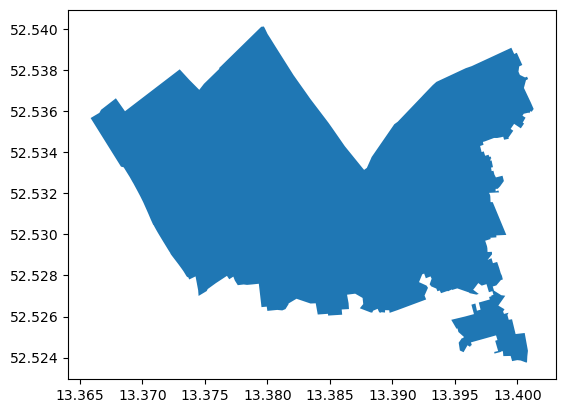

In [13]:
plz_berlin_one.plot()

## Read in the Neighborhood Laydown

In [ ]:
# Links to pull data from the DC OpenData portal

neighborhood_laydown = "https://opendata.arcgis.com/datasets/f6c703ebe2534fc3800609a07bad8f5b_17.geojson"
# If this url fails, you can download the geojson from here: https://dc.esri.com/datasets/dcdev::dc-neighborhood-clusters-1"

datasets = {
    "2021": "https://opendata.arcgis.com/datasets/da3da798fb4f4f0e9de5c3a17c39351f_10.geojson",
    "2020": "https://opendata.arcgis.com/datasets/ac617c291bbd466bbbea6272f87811d3_8.geojson",
    "2019": "https://opendata.arcgis.com/datasets/107f535e5d3347a8ac1e46dbc13669d4_6.geojson",
    "2018": "https://opendata.arcgis.com/datasets/ca581e1b455a46caa266e3476f8205d2_0.geojson",
    "2017": "https://opendata.arcgis.com/datasets/585c8c3ef58c4f1ab1ddf1c759b3a8bd_39.geojson",
    "2016": "https://opendata.arcgis.com/datasets/2dc1a7dbb705471eb38af39acfa16238_28.geojson", 
    "2015": "https://opendata.arcgis.com/datasets/b3283607f9b74457aff420081eec3190_29.geojson",
    "2014": "https://opendata.arcgis.com/datasets/54b57e15f6944af8b413a5e4f88b070c_13.geojson",
    "2013": "https://opendata.arcgis.com/datasets/3d49e06d51984fa2b68f21eed21eba1f_14.geojson",
    "2012": "https://opendata.arcgis.com/datasets/9cbe8553d4e2456ab6c140d83c7e83e0_15.geojson"
}

In [ ]:
gdf_neigh = gpd.read_file(neighborhood_laydown)

In [ ]:
gdf_neigh.head()

In [ ]:
type(gdf_neigh)

In [ ]:
gdf_neigh.crs

In [ ]:
gdf_neigh.to_crs(3857).area.sum()

In [ ]:
gdf_neigh.plot()

## Read in the Construction Permit Files

In [ ]:
df_list = []
for year, url in datasets.items():  
    gdf = gpd.read_file(url)
    gdf['year'] = year
    
    df_list.append(gdf)

In [ ]:
gdf = pd.concat(df_list)
gdf.shape

## Perform a spatial join to add cluster and neighborhood name to the permit data

In [ ]:
gdf_join = gdf.sjoin(gdf_neigh[['NAME', 'NBH_NAMES', 'geometry']], how="left", predicate="within")

In [ ]:
gdf_join.head(2)

## Create a table of counts per cluster per year

In [ ]:
counts_by_year = gdf_join.value_counts(['year', 'NAME']).to_frame().reset_index().sort_values(['NAME', 'year'])

In [ ]:
counts_by_year.columns = ['year', 'cluster', 'permit_count']
counts_by_year

## Convert that table into one row per cluster, with years as columns

In [ ]:
pivoted = counts_by_year.pivot(index="cluster", columns='year', values='permit_count')

In [ ]:
pivoted_gdf = pd.merge(pivoted, gdf_neigh[['NAME', 'NBH_NAMES', 'geometry']], how="left", left_index=True, right_on="NAME")

In [ ]:
pivoted_gdf = gpd.GeoDataFrame(pivoted_gdf, geometry='geometry', crs=4326)

In [ ]:
type(pivoted_gdf)

## Add the percent change from 2012 to 2021

In [ ]:
pivoted_gdf['perc_change'] = (pivoted_gdf['2021'] / pivoted_gdf['2012']) * 100 - 100

In [ ]:
top_10 = pivoted_gdf.sort_values('perc_change', ascending=False).head(10)

## Plot the ten clusters with the highest 'Percent Change'

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
years = top_10.columns[0:-4]
years

In [ ]:
plt.figure(figsize=(15, 5))

for idx, row in top_10.iterrows():
    plt.plot(years, row[years], label=row['NAME'])
plt.legend()

## Plot all neighborhood clusters as a map

In [ ]:
pivoted_gdf.plot(column='perc_change', cmap='RdYlGn', legend=True, figsize=(10, 10))

# Write to file

In [ ]:
pivoted_gdf.to_file("construction_counts_by_cluster_by_year.geojson", driver="GeoJSON")